In [2]:
import pandas as pd
import geopandas as gpd
import os
from datetime import datetime
import re
import numpy as np
import folium
from shapely.geometry import Point
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import sys
import matplotlib as mpl

from together import Together  # pip install together
sys.path.insert(1, '../')
from Functions import get_gentrification_scores, map_static, get_gentrification_scores_categorical

In [3]:
city = 'manchester'

In [4]:
neighbourhoods = gpd.read_file(f"../../../data/AirbnbData/airbnb-{city}/neighbourhoods.geojson")

In [5]:
lsoas =  gpd.read_file('../../../data/SpatialData/LSOAs_2011/LSOA_2011_EW_BSC_V4.shp')
manc_lads = ['Manchester', 'Rochdale', 'Bolton', 'Bury', 'Wigan', 'Oldham',  'Trafford', 'Salford', 'Tameside', 'Stockport']
pattern = '|'.join(manc_lads)
manchester_lsoas =lsoas[lsoas['LSOA11NMW'].str.contains(pattern)]

# Reproject to a CRS with meters (British National Grid)
manchester_lsoas = manchester_lsoas.to_crs(epsg=27700)

# Define Manchester city centre point (in WGS84, then project)
city_centre_wgs84 = Point(-2.2426, 53.4808)  # approx lat/lon of Manchester city centre
city_centre_point = gpd.GeoSeries([city_centre_wgs84], crs='EPSG:4326').to_crs(epsg=27700).iloc[0]

# Filter polygons within a buffer distance (e.g., 3 km radius)
buffer = city_centre_point.buffer(6000)  # 3000 meters
central_lsoas = manchester_lsoas[manchester_lsoas.intersects(buffer)]

### Join together 4 sets of listings, removing duplicates

In [14]:
listings_mar = pd.read_csv(f"../../../data/AirbnbData/airbnb-{city}/listings_mar24.csv.gz")
listings_jun = pd.read_csv(f"../../../data/AirbnbData/airbnb-{city}/listings_jun24.csv.gz")
listings_sept = pd.read_csv(f"../../../data/AirbnbData/airbnb-{city}/listings_sept24.csv.gz")
listings_dec = pd.read_csv(f"../../../data/AirbnbData/airbnb-{city}/listings_dec24.csv.gz")

In [15]:
# Add a column indicating the source dataframe
listings_mar["source"] = "Mar"
listings_jun["source"] = "Jun"
listings_sept["source"] = "Sept"
listings_dec["source"] = "Dec"

# Concatenate the two dataframes
combined = pd.concat([listings_mar, listings_jun, listings_sept, listings_dec, ], ignore_index=True)

# Group by listing ID and collect sources
# combined["source"] = combined.groupby(["id", "listing_url", 'name'])["source"].transform(lambda x: ", ".join(sorted(set(x))))
print(len(combined))

# Drop duplicates based on listing ID (keeping the first occurrence)
unique_listings = combined.drop_duplicates(subset=['id'], keep='first').copy()
print(len(unique_listings))
unique_listings = unique_listings.drop_duplicates(subset=['latitude', 'longitude'], keep='first').copy()
print(len(unique_listings))
unique_listings = unique_listings.drop_duplicates(subset=['neighborhood_overview', 'description'], keep='first').copy()
print(len(unique_listings))

26192
10109
9668
8102


In [9]:
# duplicates = combined[combined.duplicated(subset=['id'], keep=False)]
# duplicates = duplicates.sort_values(by='id')

### Add text columns combining description and neighbourhood overview

In [16]:
unique_listings['text'] = np.where(
    unique_listings[['description', 'neighborhood_overview']].isna().all(axis=1),  # Check if both are NaN
    np.nan,  # Assign NaN if both are NaN
    unique_listings['description'].fillna('') + " " + unique_listings['neighborhood_overview'].fillna(''))

### Delete listings with no textual description

In [17]:
unique_listings[unique_listings['text'].isna()][["description", "neighborhood_overview","text"]]
unique_listings = unique_listings[unique_listings['text'].notnull()]
print(len(unique_listings))

8101


### Add spatial information to listings

In [18]:
unique_listings['geometry'] = unique_listings.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
unique_listings_gdf = gpd.GeoDataFrame(unique_listings, geometry='geometry', crs="EPSG:4326")
unique_listings_gdf = unique_listings_gdf.to_crs(manchester_lsoas.crs)
unique_listings_gdf = gpd.sjoin(unique_listings_gdf, manchester_lsoas[['LSOA11NM', 'geometry']], how='left', predicate='within')

### Remove even more duplicates

In [34]:
import networkx as nx
from itertools import combinations
from fuzzywuzzy import fuzz

def deduplicate_with_logging(df, lsoa_name):
    if len(df) < 2:
        return df  # Nothing to compare

    G = nx.Graph()
    G.add_nodes_from(df.index)

    # Keep track of reasons (scores)
    match_log = []

    for i, j in combinations(df.index, 2):
        score = fuzz.ratio(df.at[i, 'text'], df.at[j, 'text'])
        if score >= 75:
            G.add_edge(i, j)
            match_log.append((i, j, score))

    groups = list(nx.connected_components(G))
    unique_indices = [sorted(group)[0] for group in groups]

    # LOG: Print duplicates
    for group in groups:
        if len(group) > 1:
            #print(f"\nDuplicates in {lsoa_name}:")
            for idx in sorted(group):
                text_snippet = df.at[idx, 'text'][:100].replace('\n', ' ')
                row = df.loc[idx]
                #print(f" - id={row['id']} | lat={row['latitude']} | lon={row['longitude']} "
                #      f"| snippet='{text_snippet}'")

            #print("  Reasons (pairwise similarity scores):")
            for i, j, score in match_log:
                if i in group and j in group:
                    #print(f"    {df.at[i, 'id']} ↔ {df.at[j, 'id']}: {score}")
                    pass 
    return df.loc[unique_indices]

results = []
for lsoa, group in unique_listings_gdf.groupby("LSOA11NM"):
    # check for duplicaed listings
    deduped = deduplicate_with_logging(group, lsoa)
   
    results.append(deduped)

# Combine results
deduplicated_listings = pd.concat(results).reset_index(drop=True)
print(len(deduplicated_listings))

7460


### Count the number of listings in each LSOA

In [64]:
# # Find the most common score in each LSOA
# count = pd.DataFrame({'Count' : deduplicated_listings.groupby("LSOA11NM").size()})
# count.reset_index(inplace=True)
# # count_filtered = count[count >8]
# count_filtered=count
# central_lsoas = central_lsoas.sort_values(by='LSOA11NM')
# central_lsoas = central_lsoas.merge(count_filtered, on='LSOA11NM', how='left')

### Filter to only keep LSOAs within a 6000m buffer zone of the centre of Manchester

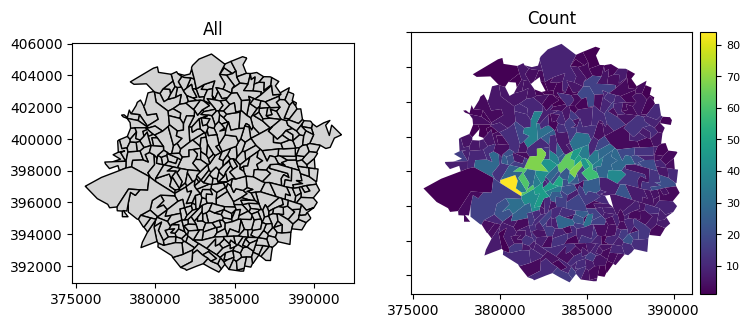

In [56]:
fig, axs = plt.subplots(ncols=2, figsize=(8, 5), sharey=True)

central_lsoas.plot(ax=axs[0], color='lightgrey', edgecolor='black')
axs[0].set_title("All")

vmin = central_lsoas['Count'].min()
vmax = central_lsoas['Count'].max()
cmap = 'viridis'
central_lsoas.plot(column='Count', ax=axs[1], cmap=cmap, vmin=vmin, vmax=vmax, legend=False)
axs[1].set_title("Count")

# Build a ScalarMappable for the colorbar
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax))
sm._A = []

# Use the second axes' position to create a colorbar axis with identical height
pos = axs[1].get_position()  # Bbox: x0, y0, width, height in figure coords
cax = fig.add_axes([pos.x1 + 0.01, pos.y0, 0.02, pos.height])  # [left, bottom, width, height]
cbar = fig.colorbar(sm, cax=cax)
cbar.ax.tick_params(labelsize=8)

### Keep only those in the central LSOAs

4949


<Axes: >

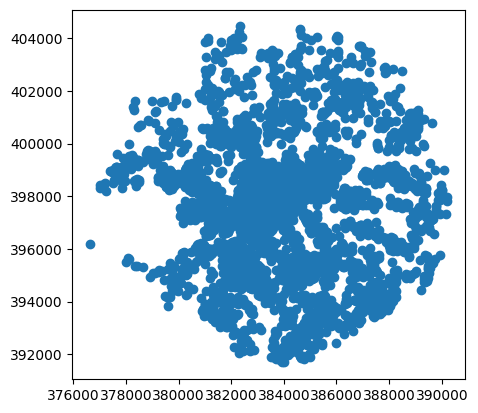

In [35]:
deduplicated_listings = deduplicated_listings[deduplicated_listings['LSOA11NM'].isin(central_lsoas['LSOA11NM'].unique())]
# del deduplicated_listings['geometry']
print(len(deduplicated_listings))
deduplicated_listings.plot()

## The prompt

In [36]:
prompt_explanatory = f"""
You are an expert in urban studies with a deep understanding of gentrification and its portrayal in public discourse. I will provide you with Airbnb 
listings, including a description of the property and a neighborhood overview. Your task is to analyze these texts and assess the gentrification status 
of the area based on how the neighborhood is presented.

Focus primarily on the neighborhood overview and description, ignoring property-specific details like the number of bedrooms, amenities, or decor. 

Consider the following:
- Direct mentions of local attractions, businesses, or community features that suggest development or revitalization.
- Language that highlights cultural hotspots, boutique shops, trendy cafes, or artisanal markets.
- Descriptions that emphasize diversity, safety, or the presence of creative communities, as these can signal gentrification dynamics.
- Listings that avoid mentioning the neighborhood or speak only broadly about the city may imply that the immediate area lacks desirable features or is 
not a selling point. This absence of detail should inform your assessment.

Assign one of the following categories:
- "Established": A well-known, desirable area with stable appeal and little active change.
- "Gentrifying": Signs of recent or ongoing transformation, such as new businesses or cultural shifts.
- "Emerging": Early indicators of gentrification potential, like creative spaces or gradual commercial interest.
- "Undeveloped": Lacking indicators of gentrification, often reflected in vague or absent neighborhood descriptions.

If a listing genuinely lacks sufficient information to make any assessment (e.g., the text is too sparse), assign a score of 'NA' and briefly explain.

Provide your answer strictly in the format:
'1. Category. Reasoning.', '2. Category. Reasoning.', etc., without any additional explanation or commentary.
"""
prompt = prompt_explanatory

## Decide whether to run LLM
Decide whether to run the LLM or load a file of scores that has been previously calculated and saved

In [37]:
# Check for existing files
base_dir = os.path.expanduser(f"../../../data/AirbnbData/airbnb-{city}/")
base_filename = "airbnb_gentrification_scores_new"
file_extension = ".gpkg"

# List all matching files in the directory
matching_files = [
    f for f in sorted(os.listdir(base_dir))
    if re.match(f"{base_filename}_\\d{{2}}{file_extension}$", f)]
matching_files

[]

In [38]:
# If there are matching files, find the most recent one
if matching_files:
    df = gpd.read_file(base_dir+matching_files[-1])
    print(f"Loaded file: {matching_files[-1]}")
else:
    # If no matching files are found
    print("No matching files found. 'df' will not be loaded.")
    df = None

No matching files found. 'df' will not be loaded.


In [39]:
RUN_LLM = True
if df is not None:
    print("Have already loaded a gentrification file, will not re-run the LLM.")
    RUN_LLM = False

RUN_LLM = True  # Optionally override

if RUN_LLM:
    print("Running LLM")
    # Get the API key from a file
    with open('../together.ai_key.txt', 'r') as f:
        api_key = f.readline().strip()

    client = Together(api_key=api_key)

    # Sample for now?
    # df = final_listings.sample(20).copy()
    df = deduplicated_listings.copy()

    print(f"Will query the LM for {len(df)} items")

    assert len(df) < 11000, "Too many tweets to process in one go. Please reduce the number of tweets."

    # Ensure the index is consecutive and ascending
    df = df.reset_index(drop=True)
    # To store the results
    df['gentrification_prediction'] = None

    # Batch processing
    batch_size = 20
    for i in range(0, len(df), batch_size):
        # Get the batch of tweets
        batch_tweets = df.loc[i:i + batch_size - 1, :]

        # Get sentiments using the function
        print(f"Submitting batch {i//len(batch_tweets)+1} of {len(df)//len(batch_tweets)}...")

        ids, sentiments, explanations = get_gentrification_scores_categorical(
            batch_tweets, prompt, client, batch_index=i, max_tokens=1500)
        # Update the DataFrame with the predictions
        df.loc[ids, 'gentrification_prediction'] = sentiments
        df.loc[ids, 'explanation'] = explanations

        # Predictions should be integers
        # df.gentrification_prediction = df.gentrification_prediction.astype('Int64')

    print("Finished querying LLM. Now saving file")

    # Initialize counter and check for existing files
    counter = 1
    while True:
        filename = f"{base_filename}_{counter:02d}.csv"
        filepath = os.path.join(base_dir, filename)
        if not os.path.exists(filepath):
            break
        counter += 1
    df.to_csv(f"{filepath}")    
    # df.set_crs(epsg=4326, inplace=True)
    # df.to_file(filepath, layer="data", driver="GPKG")
    print(f"File saved as: {filepath}")

Running LLM
Will query the LM for 4949 items
Submitting batch 1 of 247...
1. Gentrifying. The mention of Heaton Park, a large municipal park, and its various attractions suggests development and revitalization efforts in the area.
1
2. Established. The listing highlights the convenience of the location, with a 2-minute walk to Heaton Park and a tram stop, indicating a well-established and desirable area.
2
3. Gentrifying. The description of Prestwich as a "charming area" with "independent shops, cafes, and restaurants" and a "vibrant nightlife" suggests ongoing gentrification.
3
4. Emerging. The mention of "lovely independent restaurants, cafes and pubs nearby" and the convenience of transport links indicates potential for gentrification.
4
5. Established. The listing focuses on the convenience of the location for the Parklife Festival, suggesting a well-established and desirable area.
5
6. Established. The mention of the proximity to Heaton Park and the tram stop, as well as the offer